In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import sklearn as sklearn
import re
import statsmodels.api as sm
import geoplot as gplt
import geopandas as gpd
from scipy.cluster.hierarchy import dendrogram, linkage

def refresh_dico(Name,Code,df):
    dic = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dic[i[1][Name]] = i[1][Code]
    return (dic)

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    gdf = gdf.reset_index()
    gdf = gdf.set_index('Pays_indic')
    return(gdf)

def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64))/np.log10(df_norm.astype(np.float64).max()))

def geo_plot (df,indic,annee,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            print(i +' n\'a aucun équivalent dans la table des données')
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    gplt.choropleth(gdf,
                hue = annee,
                cmap = couleur,
                #norm=colors.LogNorm(vmin=gdf[annee].min(),
                #                    vmax=gdf[annee].max()),
                legend=True,
                ax=ax)
    plt.show()

In [74]:
df1 = pd.read_csv("Complete_Data.csv")
df1 = df1.set_index('Pays_indic')
dic_code = refresh_dico('Country Code','Country Name',df1)

On crée ici une liste des codes de pays, et un dictionnaire avec le nom des variables

In [75]:
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

dic = {}
dic['pib'] = '_GDP (current US$)'
dic['pib_hab'] = '_GDP (current US$) par Tete'
dic['pib_growth'] = '_GDP growth (annual %)'
dic['pib_hab_growth'] = '_Croissance_GDP (current US$) par Tete (pourcent)'
dic['pop'] = '_Population, total'
dic['ges'] = '_Émissions totales de GES (kt d’équivalent CO2)'
dic['ges_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) (pourcent)	'
dic['ges_hab'] = '_Émissions totales de GES (kt d’équivalent CO2) par Tete'
dic['ges_hab_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)'
dic['industry'] = '_Industry (including construction), value added (% of GDP)'
dic['agr'] = '_Agriculture, forestry, and fishing, value added (% of GDP)'
dic['clean_nrj'] = '_Alternative and nuclear energy (% of total energy use)'
dic['nrj_hab'] = '_Energy use (kg of oil equivalent per capita)'
dic['nrj_hab_growth'] = '_Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'

On va chercher à créer la base avec les données qui nous intéressent pour la modélisation

In [76]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            coef = results.params[1]

            return coef, r2
    
    else : return
    
def get_coeff (regresse, regresseur) :    
    dico = {}
    for code in code_list:
        dico[code] = regress(code, regresse, regresseur)
        if dico[code] == None:
            dico.pop(code)

    regress_df = pd.DataFrame(dico.values(), dico.keys(), ['Coefficient de ' + regresse + ' sur ' + regresseur,
                                                         'R2 de ' + regresse + ' sur ' + regresseur])
    return regress_df


def get_2000(var):
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :
            dic[country_code] = df1.loc[country_code + var][23]
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['2000' + var])
    
    return(temp_df)

def get_average_growth_rate(var) :
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :    
            values = list(df1.loc[country_code + var][3:])
            values = [x for x in values if ~np.isnan(x)]
            initial_value = values[0]
            final_value = values[len(values)-1]
            variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
            if variation_rate != np.inf :
                dic[country_code] = variation_rate
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['Average Growth Rate' + var])
    
    return(temp_df)

In [77]:
data = get_average_growth_rate(dic['pib_hab'])

data_list = [get_average_growth_rate(dic['agr']), get_average_growth_rate(dic['industry']), 
            get_average_growth_rate(dic['ges_hab']), get_average_growth_rate(dic['clean_nrj']),
            get_average_growth_rate(dic['nrj_hab']), 
            get_2000(dic['pib_hab']), get_2000(dic['agr']), get_2000(dic['industry']),
            get_2000(dic['ges_hab']), get_2000(dic['clean_nrj']), get_2000(dic['nrj_hab']), 
            get_coeff(dic['pib_hab'], dic['ges_hab']), get_coeff(dic['pib_hab_growth'], dic['ges_hab_growth']),
            get_coeff(dic['pib_hab'], dic['nrj_hab']), get_coeff(dic['pib_hab_growth'], dic['nrj_hab_growth'])]
for i in data_list :
    data = data.merge(i, how = 'outer', left_index = True, right_index = True)


C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


In [78]:
data.shape

(168, 20)

In [79]:
test = data.dropna(axis = 0)
test.shape

(60, 20)

In [80]:
test2 = pd.DataFrame()
for i in test.columns :
    test2[i] = preprocessing.scale(test[i])
test2.index = test.index

In [57]:
iner = []
k=3
#for k in range(2,50):
result = pd.DataFrame()
result=test2.copy()
centroid, result['Cluster'], inertie = sklearn.cluster.k_means(test2, k)
#nb_gens_cluster = []
#nb_gens = len(result.index)
#iner_inter = 0
#for i in range(0,k-1):
#    result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
#    result.where(result['Cluster'] == i).dropna()
#    nb_gens_cluster.append(len(result.where(result['Cluster'] == i).dropna().index))
#    iner_inter += (nb_gens_cluster[i]/nb_gens) *np.linalg.norm(centroid[i],ord =2)
#iner.append(inertie)
#plt.plot(np.linspace(2,50,num=49),iner)
#plt.show()

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

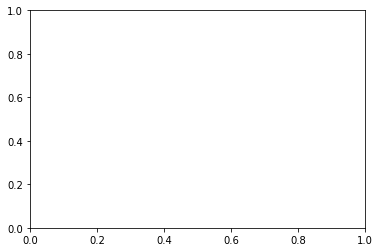

In [58]:
plt.plot(np.linspace(2,4,num=3),iner[:3])
plt.show()

In [59]:
for i in range(0,k-1):
    result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
    result.where(result['Cluster'] == i).dropna()

In [60]:
t = np.linspace(1,20,num=20)
PCA = sklearn.decomposition.PCA(2)
PCA.fit(test2)
print(PCA.singular_values_)
print(PCA.explained_variance_ratio_*100)
test3 = PCA.transform(test2)
#plt.plot(t,PCA.explained_variance_ratio_*100)
#plt.show()

[16.07102224 14.89548032]
[21.52314631 18.48961116]


In [61]:
result_ACP = pd.DataFrame(test3)
result_ACP.head()
result_ACP.index = result[:-k+1].index
result_ACP['Cluster'] = result['Cluster'][:-k+1]

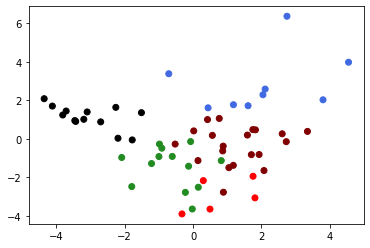

In [62]:
colormap = np.array(['black','red','royalblue','forestgreen','maroon','gold','darkgoldenrod','deeppink','mediumturquoise','orange','firebrick','silver'])
plt.scatter(result_ACP[0].to_numpy(),result_ACP[1].to_numpy(),c = colormap[result_ACP['Cluster'].astype(int).to_numpy()])
plt.show()

In [85]:
hierarc = sklearn.cluster.AgglomerativeClustering(4).fit(test2)

In [86]:
print(hierarc)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')


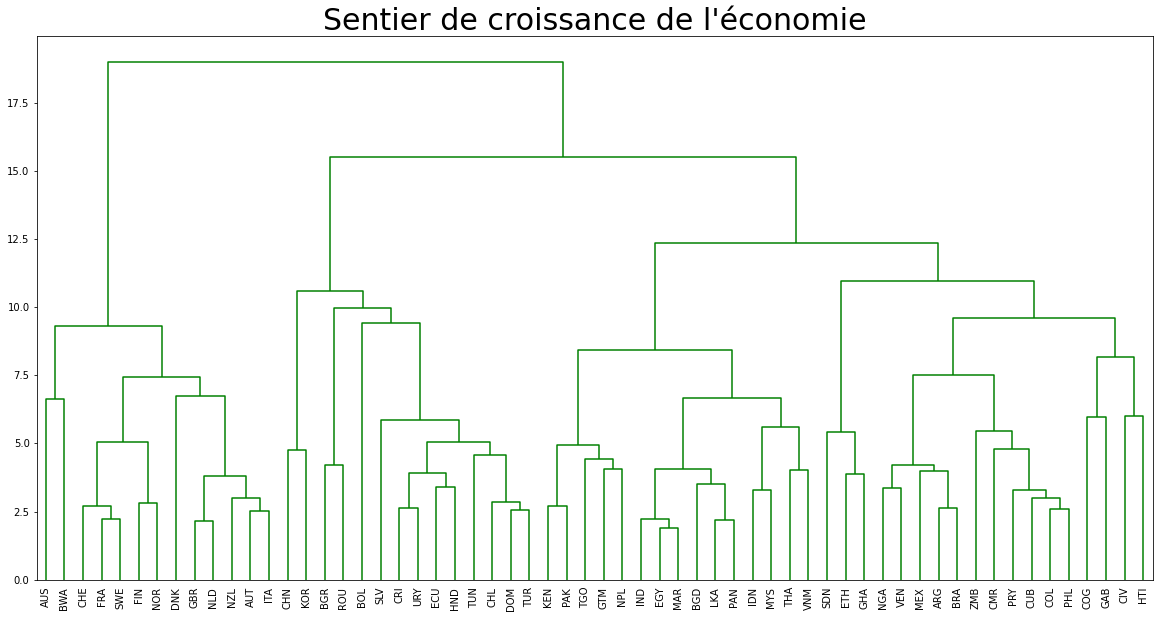

In [109]:
hierarc = linkage(test2,method='ward',metric='euclidean')

fig = plt.subplots(figsize=(20,10))
dendrogram(hierarc, labels=test2.index, orientation='top', color_threshold=1000, leaf_font_size=10) 
plt.title("Sentier de croissance de l'économie", fontsize=30)

plt.show()

